# Classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from ipywidgets import FloatProgress
from matplotlib.colors import ListedColormap
from sklearn import ensemble, cross_validation, learning_curve, metrics, multiclass, preprocessing, grid_search
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def tolerant_score(expected, predicted):
    score = 0.
    for one, two in zip(expected, predicted):
        for xx, yy in zip(one, two):
            if xx == yy:
                score += 0.33
    return score / len(expected)

In [3]:
def plot_confusion_matrix(matrix, labels):
    pylab.clf()
    pylab.figure(figsize = (7, 7))
    pylab.matshow(matrix, fignum=False, cmap='Blues', vmin=0., vmax=1.0)
    
    ax = pylab.axes()
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    
    pylab.title('Confusion matrix')
    pylab.colorbar()
    pylab.grid(False)
    pylab.xlabel('Predicted')
    pylab.ylabel('Actual')
    
    pylab.show()

In [4]:
data = pd.read_csv('threeclassdatamfcc.csv', index_col='Unnamed: 0')

X = data.drop(['Label', 'Bands mean', 'Coefs mean'], axis = 1)
y = data['Label']

pia_border = np.where(data['Label'] == 0)[0][-1:][0]
vio_border = np.where(data['Label'] == 1)[0][-1:][0]

pia_data = data.drop(['Label', 'Bands mean', 'Coefs mean'], axis = 1)
pia_data['Label'] = np.hstack([np.ones(pia_border), np.zeros(len(data) - pia_border)])
X_pia = pia_data.drop('Label', axis = 1)
y_pia = pia_data['Label']

vio_data = data.drop(['Label', 'Bands mean', 'Coefs mean'], axis = 1)
vio_data['Label'] = np.hstack([np.zeros(pia_border), np.ones(vio_border - pia_border),
                               np.zeros(len(data) - vio_border)])
X_vio = vio_data.drop('Label', axis = 1)
y_vio = vio_data['Label']

gac_data = data.drop(['Label', 'Bands mean', 'Coefs mean'], axis = 1)
gac_data['Label'] = np.hstack([np.zeros(vio_border), np.ones(len(data) - vio_border)])
X_gac = gac_data.drop('Label', axis = 1)
y_gac = gac_data['Label']

In [5]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.3, stratify = y)

sc = preprocessing.StandardScaler()

X_train = preprocessing.StandardScaler.fit_transform(sc, X_train)
X_test = preprocessing.StandardScaler.transform(sc, X_test)

(X_pia_train,
X_pia_test,
y_pia_train,
y_pia_test) = cross_validation.train_test_split(X_pia, y_pia,
                                                test_size = 0.3, stratify = y_pia)

X_pia_train = preprocessing.StandardScaler.fit_transform(sc, X_pia_train)
X_pia_test = preprocessing.StandardScaler.transform(sc, X_pia_test)

(X_vio_train,
X_vio_test,
y_vio_train,
y_vio_test) = cross_validation.train_test_split(X_vio,  y_vio,
                                                test_size = 0.3, stratify = y_vio)

X_vio_train = preprocessing.StandardScaler.fit_transform(sc, X_vio_train)
X_vio_test = preprocessing.StandardScaler.transform(sc, X_vio_test)

(X_gac_train,
X_gac_test,
y_gac_train,
y_gac_test) = cross_validation.train_test_split(X_gac, y_gac,
                                                test_size = 0.3, stratify = y_gac)

X_gac_train = preprocessing.StandardScaler.fit_transform(sc, X_gac_train)
X_gac_test = preprocessing.StandardScaler.transform(sc, X_gac_test)

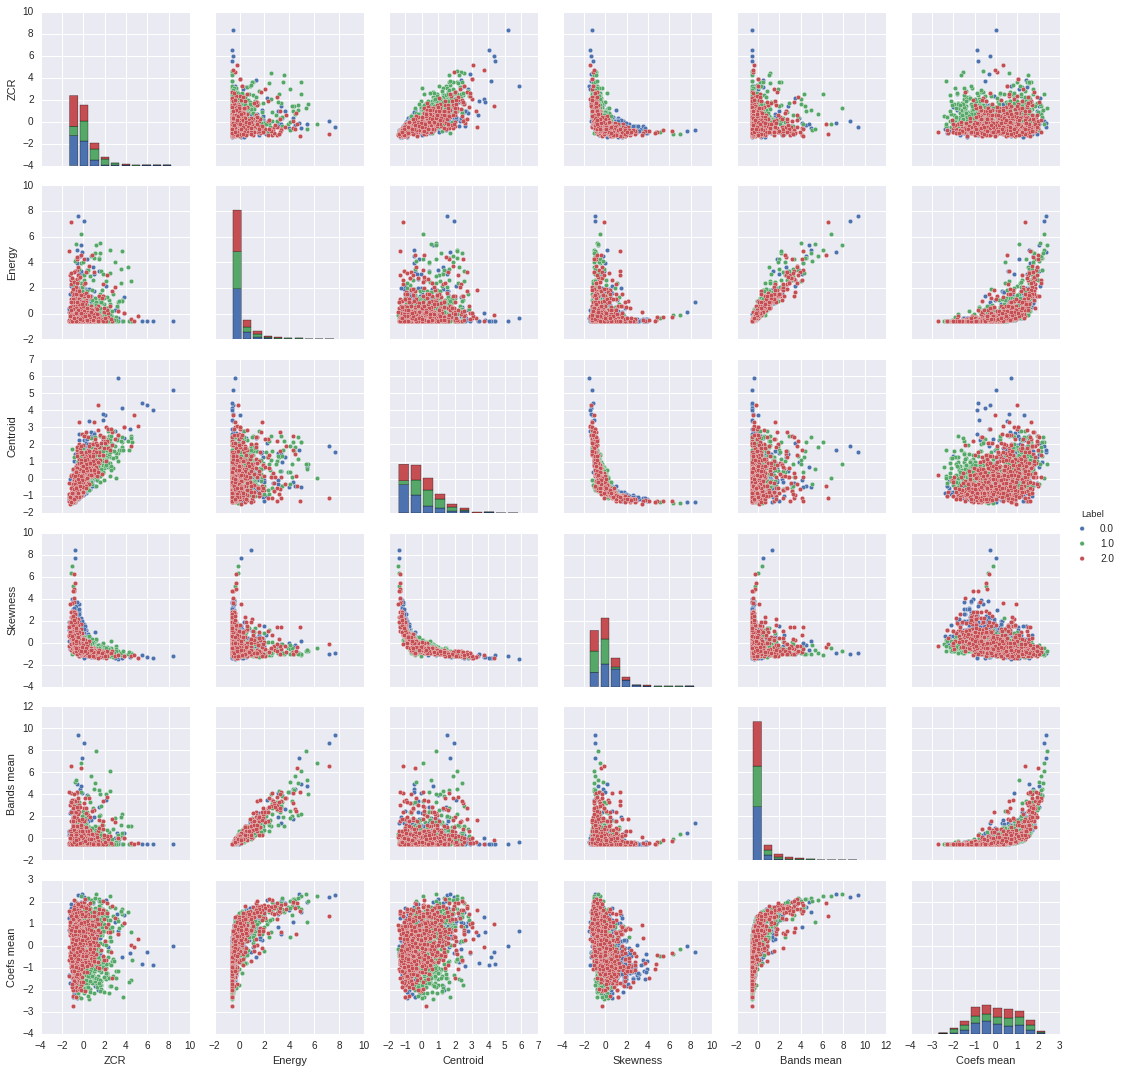

In [6]:
view = pd.DataFrame(data = preprocessing.StandardScaler.fit_transform(sc, data.drop('Label', axis = 1)),
                           columns = [x for subarr in [['ZCR'],
                                                      ['Energy'],
                                                      ['Centroid'],
                                                      ['Variance'],
                                                      ['Skewness'],
                                                      ['Kurtosis'],
                                                      ['MFCC%d' % i for i in xrange(53)],
                                                      ['Bands mean'],
                                                      ['Coefs mean']] for x in subarr])
view['Label'] = y
pairgrid = sns.pairplot(view, hue = 'Label', vars = ['ZCR', 'Energy', 'Centroid', 'Skewness', 'Bands mean', 'Coefs mean'])
pairgrid.savefig('pairplotscaled.png')

## RandomForest

### Single label

In [7]:
estimator = ensemble.RandomForestClassifier()

In [8]:
rf_params = {'n_estimators': range(1, 50, 3),
          'max_depth': range(1, 20, 1),
          'min_samples_leaf': range(1, 10, 1)}
cv = 5

In [9]:
optimizer = grid_search.RandomizedSearchCV(estimator=estimator, param_distributions=rf_params, cv=cv)

In [10]:
%%time
optimizer.fit(X_train, y_train)

print 'Time elapsed:'

Time elapsed:
CPU times: user 10 s, sys: 20 ms, total: 10 s
Wall time: 10 s


In [11]:
print optimizer.best_params_

{'n_estimators': 49, 'max_depth': 14, 'min_samples_leaf': 2}


In [12]:
score = optimizer.score(X_test, y_test)
print score

0.670103092784


In [13]:
matches = 0

for one, two in zip(y_test[:20], optimizer.predict(X_test)[:20]):
    print int(one), int(two), one == two

for one, two in zip(y_test, optimizer.predict(X_test)):
    if one == two:
        matches += 1

print 'Matches: %d\nNon-matches: %d' % (matches, len(y_test) - matches)

0 1 False
2 2 True
2 1 False
0 0 True
1 1 True
0 0 True
0 2 False
2 2 True
2 2 True
2 2 True
1 1 True
2 2 True
0 0 True
2 1 False
1 2 False
2 2 True
0 1 False
2 2 True
0 0 True
0 0 True
Matches: 390
Non-matches: 192


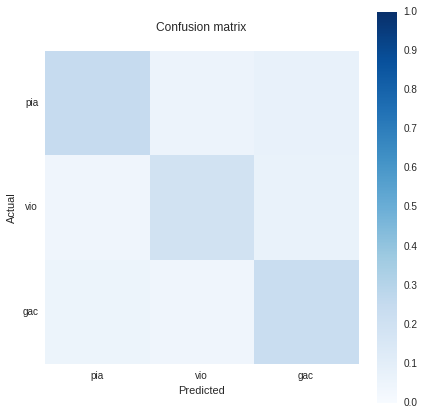

In [14]:
matrix = metrics.confusion_matrix(y_test, optimizer.predict(X_test)) / float(len(y_test))
plot_confusion_matrix(matrix, ['pia', 'vio', 'gac'])

Predicting probabilities might also be a good idea

### Multilabel

The data might not be multi-label, but let's give it a try. Unsurprisingly, ```sklearn``` already has multi-label classifier.

In [15]:
%%time
Y_train = preprocessing.MultiLabelBinarizer().fit_transform([[y] for y in y_train])
Y_test = preprocessing.MultiLabelBinarizer().fit_transform([[y] for y in y_test])

base = ensemble.RandomForestClassifier()
optimizer = grid_search.RandomizedSearchCV(estimator=base, param_distributions=rf_params, cv=cv)

clf = multiclass.OneVsRestClassifier(optimizer)
clf.fit(X_train, Y_train)

score = clf.score(X_test, Y_test)
tolerant = tolerant_score(Y_test, clf.predict(X_test))

print 'Exact matches accuracy: %f' % score
print 'Tolerant matches accuracy: %f' % tolerant
print '\nTime elapsed:\n'

Exact matches accuracy: 0.500000
Tolerant matches accuracy: 0.767732

Time elapsed:

CPU times: user 20.9 s, sys: 104 ms, total: 21 s
Wall time: 21 s


In [16]:
print 'Expect    Real  Equal'
for one, two in zip(Y_test, clf.predict(X_test)[:20]):
    print one, two, (one == two).all()
    
trues = 0
zeros = 0
for one, two in zip(Y_test, clf.predict(X_test)):
    if (one == two).all():
        trues += 1
    if (two == 0).all():
        zeros += 1

print 'Matches: %d\nNon-matches: %d\nFully zero: %d (is %.2f of all)' % (trues,
                                                                         len(Y_test) - trues, zeros,
                                                                         float(zeros) / len(Y_test))

Expect    Real  Equal
[1 0 0] [0 0 0] False
[0 0 1] [0 0 1] True
[0 0 1] [0 0 0] False
[1 0 0] [1 0 0] True
[0 1 0] [0 1 0] True
[1 0 0] [1 0 0] True
[1 0 0] [0 0 0] False
[0 0 1] [0 0 1] True
[0 0 1] [0 0 0] False
[0 0 1] [0 0 0] False
[0 1 0] [0 1 0] True
[0 0 1] [0 0 0] False
[1 0 0] [0 0 1] False
[0 0 1] [0 0 0] False
[0 1 0] [0 0 0] False
[0 0 1] [0 0 1] True
[1 0 0] [0 1 0] False
[0 0 1] [0 0 1] True
[1 0 0] [1 0 1] False
[1 0 0] [1 0 0] True
Matches: 291
Non-matches: 291
Fully zero: 179 (is 0.31 of all)


The quality is poor due to one main reason — the metric is strict and only allows exact match of prediction to test label. The data might also not be multi-label, so we are mistaken a lot. Also, in 30% of test data the algorithm doesn't know what to answer — I think it deals with dropouts.

## XGBoost

### Single label

In [17]:
estimator = xgb.XGBClassifier()

In [18]:
xgb_params = {'n_estimators': range(1, 50, 3),
              'max_depth': range(1, 20, 1)}

In [19]:
optimizer = grid_search.RandomizedSearchCV(estimator=estimator, param_distributions=xgb_params, cv=cv)

In [20]:
%%time
optimizer.fit(X_train, y_train)

CPU times: user 1min 11s, sys: 500 ms, total: 1min 11s
Wall time: 42 s


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=0)

In [21]:
score = optimizer.score(X_test, y_test)

print score
print optimizer.best_params_

0.682130584192
{'n_estimators': 34, 'max_depth': 10}


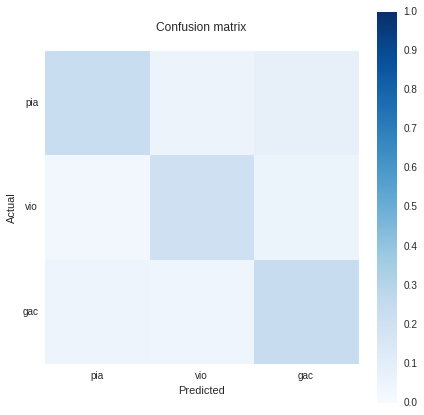

In [22]:
matrix = metrics.confusion_matrix(y_test, optimizer.predict(X_test)) / float(len(y_test))
plot_confusion_matrix(matrix, ['pia', 'vio', 'gac'])

Basically a little better than RandomForest. Won't try multi-label for now.